# Scikit-Learn Pipelines for churn

This notebook accompanies [this blog post](http://philipmgoddard.com/modeling/sklearn_pipelines) to demonstrate the usage of machine learning pipelines using Scikit-Learn. The churn dataset from the R C.50 package is used as an example.

I use [conda](https://conda.io/docs/index.html) to manage my Python environments: you can use environment.yml to rebuild my environment. 

__This contains updates, where I demonstrate how to use a factory method and mixins to incorporate sampling methods into your pipelines.__

In [1]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# imports for piplelines
from sklearn.pipeline import Pipeline, FeatureUnion

# built-in transformer which we will use in our pipelines
from sklearn.preprocessing import PolynomialFeatures

#evaluation metrics  
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve

# models and model selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# custom imports
from custom_transformers import DataFrameSelector, ZeroVariance, FindCorrelation
from custom_transformers import OptionalStandardScaler, ManualDropper, PipelineChecker

from ml_plot import kde_plot, hist_plot, cat_plot, pairwise_plot, LiftChart, ROCPlot, train_plot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Churn data with pipelines

We will be working with the familiar churn dataset from the R C.50 package. I have used this as a toy example several time, so we can gloss over some data exploration, and I can refer you to previous examples where I explore the data set in a little more detail.

In [2]:
# load into dataframe
churnTrain = pd.read_csv('churnTrain.csv')
churnTest = pd.read_csv('churnTest.csv')

# split features and outcome, and transform outcome to binary
features = [x for x in churnTrain if x != 'churn']
features_train = churnTrain[features]
features_test = churnTest[features]
outcome_train = churnTrain.loc[:, 'churn'].apply(lambda x: 1 if x == "yes" else 0)
outcome_test = churnTest.loc[:, 'churn'].apply(lambda x: 1 if x == "yes" else 0)

In [3]:
print('{} \n\nunique dtypes: {}'.format(features_train.info(),
                                        set([features_train[x].dtype for x in features_train])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
state                            3333 non-null object
account_length                   3333 non-null int64
area_code                        3333 non-null object
international_plan               3333 non-null object
voice_mail_plan                  3333 non-null object
number_vmail_messages            3333 non-null int64
total_day_minutes                3333 non-null float64
total_day_calls                  3333 non-null int64
total_day_charge                 3333 non-null float64
total_eve_minutes                3333 non-null float64
total_eve_calls                  3333 non-null int64
total_eve_charge                 3333 non-null float64
total_night_minutes              3333 non-null float64
total_night_calls                3333 non-null int64
total_night_charge               3333 non-null float64
total_intl_minutes               3333 non-null float64
total_intl_calls           

## Split categorical and numerical into seperate dataframes, as they require different preprocessing steps

For instance, we need to one-hot encode categorical features to obtain numerical values that can be fed into sk-learn models.

In [4]:
fac_cols = [x for x in features_train if features_train[x].dtype == np.dtype('O')]
float_cols = [x for x in features_train if features_train[x].dtype == np.dtype('float64')]
int_cols = [x for x in features_train if features_train[x].dtype == np.dtype('int64')]

# convert objects into pandas categorical type
# get a warning (suppressed here), but we are OK
features_train.loc[:, fac_cols] = features_train.loc[:, fac_cols].apply(lambda x: pd.Categorical(x))
features_test.loc[:, fac_cols] = features_test.loc[:, fac_cols].apply(lambda x: pd.Categorical(x))

We have a concern here: what would happen if a categorical value appeared in the test set that was not encountered in the training set? It would be a disaster for the automated pipeline we are going to build.

We have to be very careful here. Here is a simple function (its expressive rather than efficient) to test whether we have any issues for this toy data set.

In [5]:
def category_checker(X_train, X_test, cat_col):
    allowed_values = dict()
    for col in cat_col:
        allowed_values[col] = X_train[col].values.categories
    
    warn = False
    for col in cat_col:
        tmp = X_test[col].values.categories
        for val in tmp.values.tolist():
            if val not in allowed_values[col].values.tolist():
                print('WARNING: new categorical level encountered:', col, val)
                warn = True
    
    if not warn:
        print('No problems detected')

# we see that there are no categories in the test set that do not appear 
# in the training set
category_checker(features_train, features_test, fac_cols)

No problems detected


## Data exploration

I have investigated the features in previous blog posts - see [here](https://github.com/philipmgoddard/pycaret_demo/blob/master/pycaret_churn.ipynb) for instance.
I will leave some code for you to run should you be interested

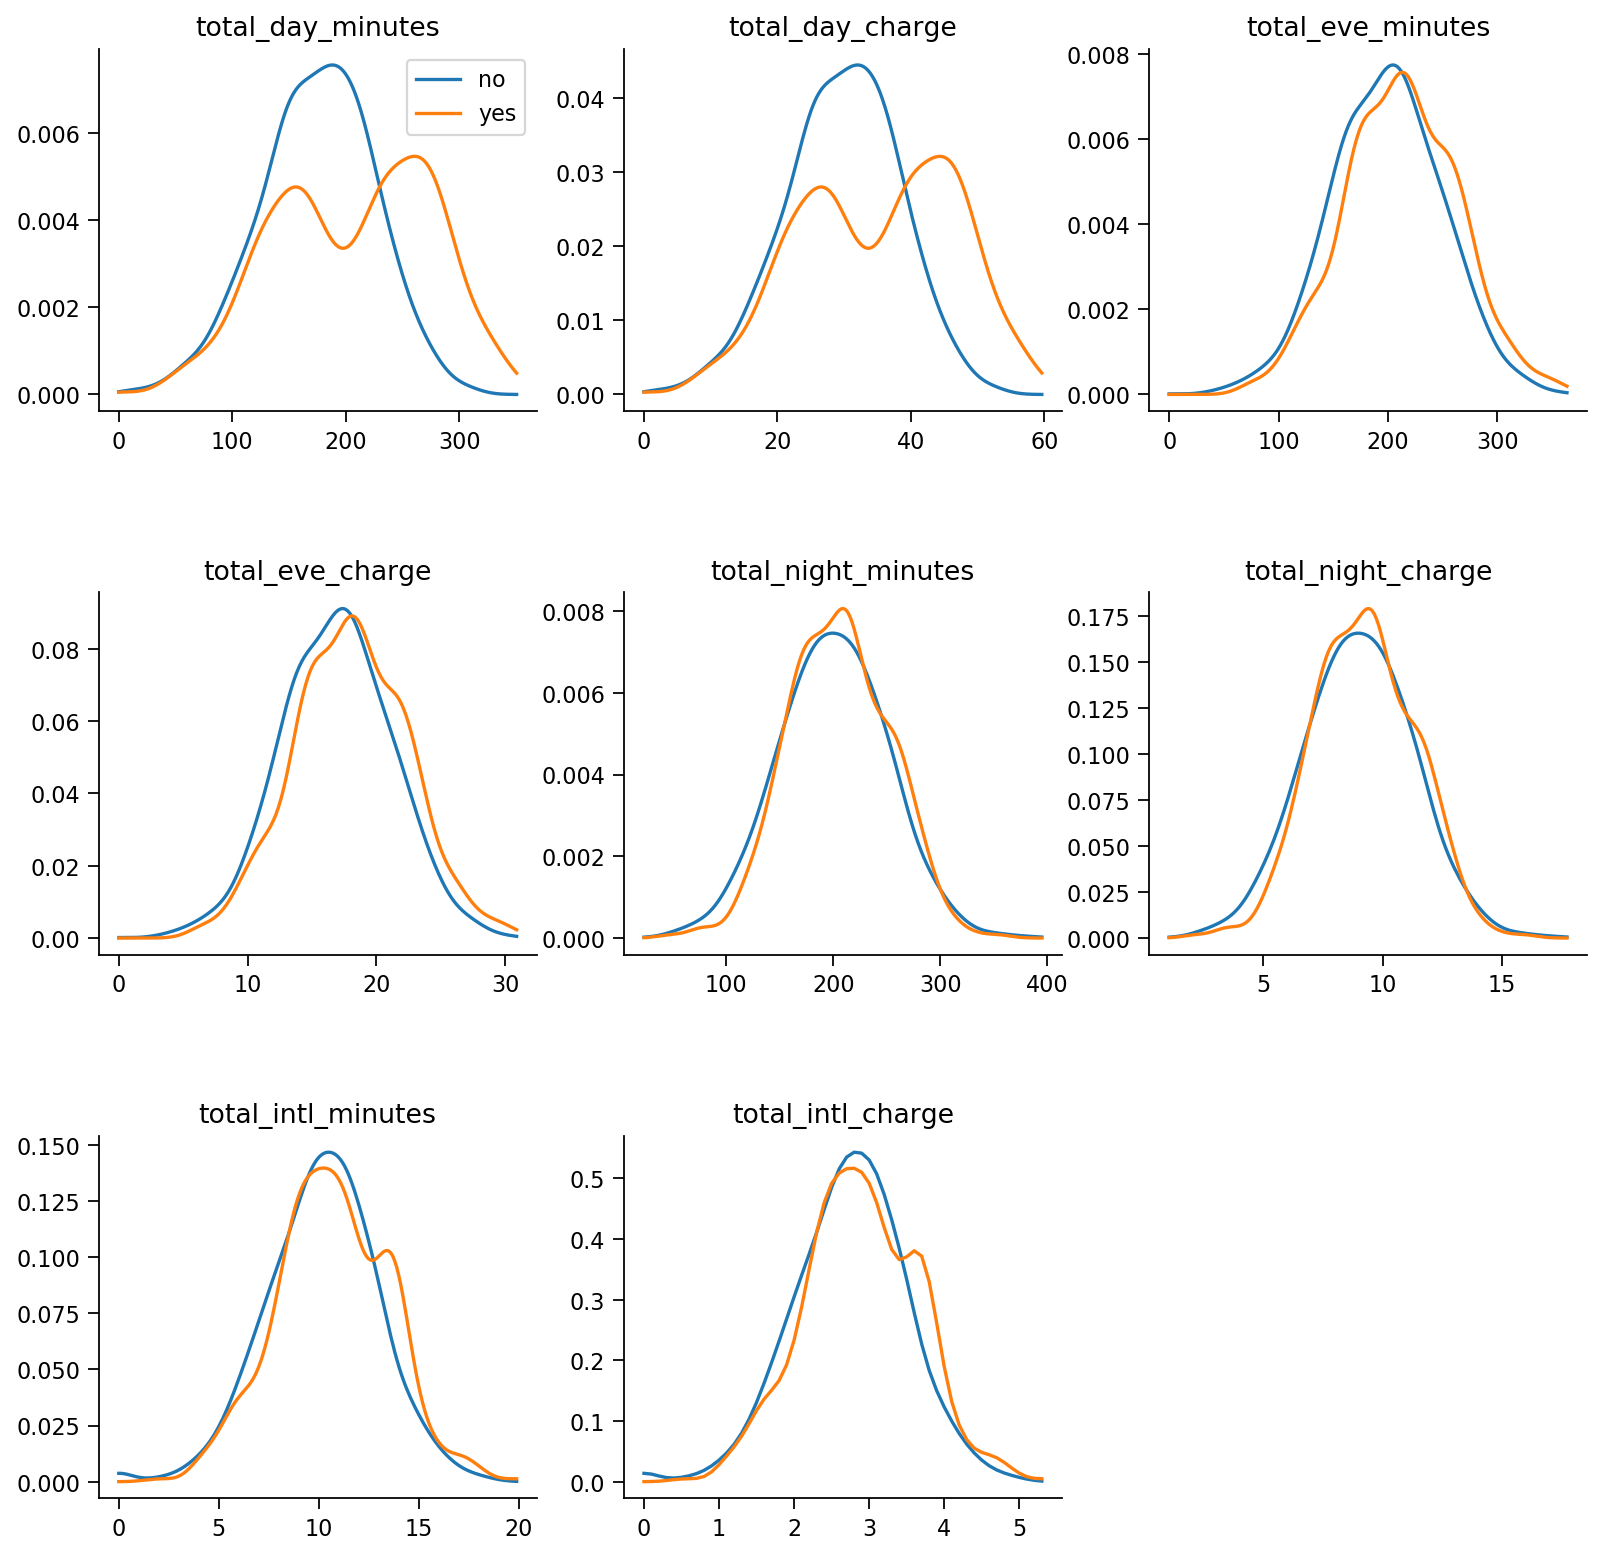

In [6]:
#-----------------------------------------------------------
#
# As an example, kernel density plots for numerical features.
#
#-----------------------------------------------------------

kde_plot(churnTrain.loc[:, float_cols  + ['churn']],
         outcome_col = 'churn',
         n_col = 3,
         plot_legend = True,
         f_size = (12,12))

In [7]:
#-----------------------------------------------------------
#
# Histograms for numerical features.
# Uncomment code below and run cell to produce.
# You may want to try hist_plot as well
#-----------------------------------------------------------

# hist_plot(churnTrain.loc[:, float_cols  + ['churn']],
#          outcome_col = 'churn',
#          n_col = 3,
#          plot_legend = True,
#          f_size = (12,12))

In [8]:
#-----------------------------------------------------------
#
# Bar charts for categorical features
# Uncomment code below and run cell to produce
#
#-----------------------------------------------------------

# cat_plot(churnTrain.loc[:, fac_cols + ['churn']],
#          outcome_col = 'churn',
#          n_col = 2,
#          plot_legend = True,
#          f_size = (22,12))

In [9]:
#-----------------------------------------------------------
#
# Pairwise plot to investigate correlations
# amongst numberical features (you may want to investigate)
# correlation between categorical features as well!)
# Uncomment code below and run cell to produce
#
#-----------------------------------------------------------

# pairwise_plot(churnTrain.loc[:, float_cols + int_cols + ['churn']],
#          outcome_col = 'churn',
#          f_size = (10,10))

## Do as much preperation before the pipeline as possible

Take it from me, performing one-hot encoding and keeping track of feature names in a pipeline can be exceedingly messy. Pandas is designed for data munging, so use it to prepare your data as much as you can!

The rule of thumb I use is: could the preprocessing step be used as a hyperparameter? If yes, it should be in the pipeline. If no, do outside.

As sklearn can only run on numerical data, we would __always__ want to one hot encode categorical features. Therefore it should be done outside the pipeline. 

As a counter example, perhaps we are not sure if we should center and scale the features. Therefore, this optional scaling should be performed within the pipeline, and we would toggle it on and off (treat it like a hyperparameter) when performing cross validation for the pipeline.

In [10]:
# pandas has helper function for creating dummies- much easier than
# using sklearn helper classes
fac_dummies_train = pd.get_dummies(features_train.loc[:, fac_cols])

# Need to drop: international_plan_no, voice_mail_plan_no as these are binary.
# We could optionally drop: area_code_408, state_AK: for linear models these 
# could be considered as the base class.
# For now, we can store these column names in a list.
drop_cols = ["international_plan_no", 'voice_mail_plan_no']
opt_drop_cols = ['state_AK', 'area_code_area_code_408']

# what are the column indices? Remember, sk-learn uses numpy arrays,
# not pandas dataframes, so we can only index by column index
fac_col_names = fac_dummies_train.columns.values
drop_col_ix = [np.where(fac_col_names == x)[0][0] for x in drop_cols]
opt_drop_col_ix = [np.where(fac_col_names == x)[0][0] for x in opt_drop_cols]

In [11]:
# Combine numerical and encoded categorical dataframes.
# This is where we will pass over to our pipeline
features_train = fac_dummies_train.merge(features_train.loc[:, int_cols + float_cols],
                                         left_index = True, right_index = True)

## Pipeline

Lets break down our pipeline into stages: in this case, we want to perform some feature selection (e.g. drop low variance features), data preprocessing (calculate polynomial features) before we fit an estimator (our learning algorithm).

We can consider seperate stages we want to perform for numerical and categorical features before we fit a model. Scikit Learn has a handy FeatureUnion class, which allows us to perform a stage of the pipeline in parrallel, and combine the results before we move on to the next step. 

Lets think what we want to do for the numerical and categorical features. We will later combine these using a feature union, as they should be performed in parrallel, not sequentially.

For numerical we want to:
- select numerical features from our input
- remove zero variance features, and optionally low variance features
- check for any correlations and remove if above a threshold
- scale the data (OptionalStandardScaler allows us to toggle this on or off)
- calculate polynomial features (interactions). This can be toggled as if degree = 1 it will just return original features

For categorical data we want to:
- select categorical features
- drop columns where the category was binary, as we know the two columns will be fully correlated. Also, we can optionally drop further columns, which may be useful for linear models if we want one level from each categegory to be the 'baseline'
- remove zero variance features, and optionally low variance features
- check for any correlations and remove if above a threshold

Other than PolynomialFeatures, all the transformers are custom written. Feel free to use! :)

In [12]:
# data pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(float_cols + int_cols)),
    ('zero_var', ZeroVariance(near_zero=True)),
    ('correlation', FindCorrelation(threshold=0.9)),
    ('opt_scaler', OptionalStandardScaler(scale=False)),
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
])

# data pipeline for categorical features
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(fac_col_names)),
    ('manual_dropper', ManualDropper(drop_ix = drop_col_ix,
                                     optional_drop_ix=opt_drop_col_ix)),
    ('zero_var', ZeroVariance(near_zero=True)),
    ('correlation', FindCorrelation(threshold=0.9)),
])

### Aside: recovering feature names

One difficulty I encountered was reconstructing labels once we have run data through the pipeline.
Numpy isn't really the best tool for holding metadata associated with the array- that is where Pandas shines.

Here is a little example of how to recover a dataframe with named columns after running the data through the pipeline.

In [13]:
#-----------------------------------------------------------
#
# example: run through num_pipeline.
# Get back an numpy array. 
# Note that all same datatype now: numpy can only consider
# homogenous data types, so integer converted to float.
#
#-----------------------------------------------------------

num_arr = num_pipeline.fit_transform(features_train)
# first 5 rows
print(num_arr[:5, :])

[[ 45.07  16.78  11.01   2.7  128.   110.    99.    91.     3.     1.  ]
 [ 27.47  16.62  11.45   3.7  107.   123.   103.   103.     3.     1.  ]
 [ 41.38  10.3    7.32   3.29 137.   114.   110.   104.     5.     0.  ]
 [ 50.9    5.26   8.86   1.78  84.    71.    88.    89.     7.     2.  ]
 [ 28.34  12.61   8.41   2.73  75.   113.   122.   121.     3.     3.  ]]


In [14]:
#-----------------------------------------------------------
#
# We can access steps in the fitted pipeline using get_params() method.
# We want to access the get_feature_names() method in each step, which 
# will allow us to filter an array of names at each step to correspond to 
# the features that are being selected
#
#-----------------------------------------------------------

# step 1: those filtered by low variance
names_1 = num_pipeline.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
# step 2: those filtered by correlation. Pass in the remaining names from the previous step
names_2 = num_pipeline.get_params()['correlation'].get_feature_names(names_1)
# step3: those from interaction
names_3 = num_pipeline.get_params()['poly_features'].get_feature_names(names_2)

# and prove we have recovered names...
pd.DataFrame(num_arr, columns=names_3).head()

,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge,account_length,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
0,45.07,16.78,11.01,2.70,128.0,110.0,99.0,91.0,3.0,1.0
1,27.47,16.62,11.45,3.70,107.0,123.0,103.0,103.0,3.0,1.0
2,41.38,10.30,7.32,3.29,137.0,114.0,110.0,104.0,5.0,0.0
3,50.90,5.26,8.86,1.78,84.0,71.0,88.0,89.0,7.0,2.0
4,28.34,12.61,8.41,2.73,75.0,113.0,122.0,121.0,3.0,3.0


### Putting together the pipeline

We will create a FeatureUnion of the numerical and categorical pipeline. This ensures they run in parralel- if they ran sequentially the results of one would be the input of the next, which we certainly dont want!

Following the feature union of the numerical and categorical pipeline, we perform a final correlation check, and a basic pipeline check via the PipelineChecker. At present this only ensures the train and test feature array have the same number of columns, but I will extend in future to check values as well (e.g. for outliers that will cause the model to be extrapolating, and may be producing unreliable results).

This pipeline can be used as a template, and we can append a final estimator (i.e. learning algorithm) to the end, allowing us to examine different models in isolation. I have seen people use a bunch of estimators in the same pipeline (so the model chooses the best by CV criteria), but I prefer to have more control and study the models in isolation.

In [15]:
#-----------------------------------------------------------
#
# Use feature union to make a big pipeline
#
#-----------------------------------------------------------

prep_pipe = Pipeline([
        
    ('union', FeatureUnion(
        transformer_list = [
                    
            # pipeline to transform numeric features
            ('num_pipeline', num_pipeline),
                    
            # pipeline for categorical
            ('cat_pipeline', cat_pipeline),
        ],
                
        #other arguments for FeatureInion        
        n_jobs = 1,
        transformer_weights = None
    )),
        
    # final correlation check
    ('correlation', FindCorrelation(threshold=0.9)),
        
    # error checking
    ('checker', PipelineChecker()),
])


## Modelling

The main joy of pipelines is that we can treat the preprocessing steps as hyperparameters! Lets dig into a couple of examples to show why this is so useful

### Logistic regression

Firstly, we will consider a logistic regression. We know that this is a linear model, so a hyperparameter we want to consider is the degree of polynomial terms (1 or 2). Degree 1 corresponds to the original data. We need to be careful going higher than degree 2 as we will quickly start to overfit, or encounter problems when we have more features than rows.

Also, we want to try scaling and not scaling the data. For a linear model, this can be useful for examining feature importance. OptionalStandardScaler is simply a wrapper around StandardScaler that allows the scaling to be toggled on or off (we will try both when performing cross validation to find the best results).

Other than that, I will use an l1 penalty, and several values of C to tune the logistic regression. In principle, I could investigate even more parameters, but the number of models you must train and evaluate blows up very quickly, especially with the 5-fold CV I am using.

In [16]:
# logistic regression. take a copy of the pipeline, and append an estimator to the end
lr_est = copy.deepcopy(prep_pipe)
lr_est.steps.append(('logistic_regression', LogisticRegression(random_state = 1234)))

In [17]:
# set the hyperparameter grid. Good news: we can treat preprocessing steps as we would
# any other hyperparameter. Be careful though, as can easily blow up number of models 
# will be building (especially with CV as well)
lr_param_grid = dict(union__num_pipeline__opt_scaler__scale=[True, False],
                  union__num_pipeline__poly_features__degree=[1,2],
                  logistic_regression__penalty=['l1'],
                  logistic_regression__C=[0.001, 0.01, 0.1, 1, 10])

We will use a GridSearchCV object to perform our grid search, using 5-fold CV. We will assess models with the ROC AUC. Here, I set n_jobs to 1 (as I expect linear models to fit quickly), but in principle this is an embarrasingly parallel problem, so I could use multiple threads.

In [18]:
# cross validation object
grid_search_lr = GridSearchCV(estimator=lr_est,
                              param_grid=lr_param_grid,
                              scoring='roc_auc',
                              n_jobs=1,
                              cv=5,
                              refit=True,
                              verbose=1)

grid_search_lr.fit(features_train, outcome_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.6s finished


In [19]:
# GridSearchCV object has many useful attributes, for example:
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_lr.best_params_,
                                                        grid_search_lr.best_score_))

Chosen params: {'logistic_regression__C': 0.1, 'logistic_regression__penalty': 'l1', 'union__num_pipeline__opt_scaler__scale': True, 'union__num_pipeline__poly_features__degree': 2}

Train AUC score: 0.880


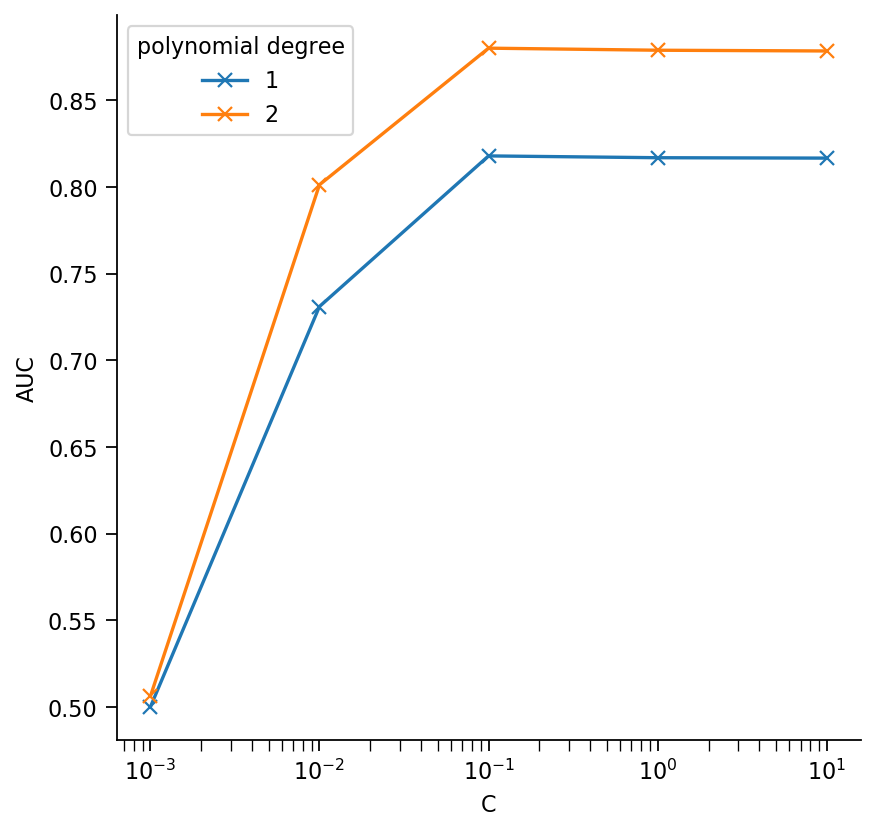

In [20]:
#-----------------------------------------------------------
#
# Visualise CV results
#
# Cannot look at everything, so we will consider the mean AUC of test folds 
# as a function of polynomial degree and penalty. 
#
#-----------------------------------------------------------

# results are stored as dict, lets pull into a dataframe
lr_results = pd.DataFrame(grid_search_lr.cv_results_)

plt_cols = ['param_union__num_pipeline__poly_features__degree',
            'param_logistic_regression__C',
            'mean_test_score',
            'std_test_score']

# filter and rename for neat plotting
lr_results = (lr_results.query('param_union__num_pipeline__opt_scaler__scale == True')
                 .loc[:, plt_cols]
                 .rename(columns = {'param_logistic_regression__C' : 'C',
                                    'param_union__num_pipeline__poly_features__degree' : 'polynomial degree',
                                    'mean_test_score' : 'AUC'
                                    })
)

# train plot is a plotting helper function for visualising hyperparameter training.
# it can consider up to three hyperparameters, and optionally can plot
# error bars. See ml_plots.py for the source code
train_plot(lr_results, logx=True)

### Aside: recovering feature names following the pipeline

We saw before that this can be done- lets apply same techniques to the full pipeline. Note that this is by design that this is possible- I added get_feature_names methods to all my custom transformers.

In [21]:
# rebuild features. Notice we selected polynomial degree 2 after cross validation,
# so we have lot of extra features

# can access parts of the CV pipeline object like so:
num_pipe_lr = grid_search_lr.best_estimator_.get_params()['union__num_pipeline']
cat_pipe_lr = grid_search_lr.best_estimator_.get_params()['union__cat_pipeline']

# names from numerical pipeline
names_1a = num_pipe_lr.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
names_2a = num_pipe_lr.get_params()['correlation'].get_feature_names(names_1a)
names_3a = num_pipe_lr.get_params()['poly_features'].get_feature_names(names_2a)

# names from categorical pipeline
names_1b = cat_pipe_lr.get_params()['manual_dropper'].get_feature_names(np.array(fac_col_names))
names_2b = cat_pipe_lr.get_params()['zero_var'].get_feature_names(np.array(names_1b))
names_3b = cat_pipe_lr.get_params()['correlation'].get_feature_names(np.array(names_2b))

# names following final correlation check
names_1c = np.array(names_3a + names_3b.tolist())
lr_feature_names = grid_search_lr.best_estimator_.get_params()['correlation'].get_feature_names(names_1c)

In [22]:
#-----------------------------------------------------------
#
# We can use this usefully: lets examine the coefficient of each 
# feature
#
#-----------------------------------------------------------

# coefficients are in the best_estimator_ attribute
lr_coef = grid_search_lr.best_estimator_.get_params()['logistic_regression'].coef_

# we can sort the list by coef, absolute coef etc. Display the top 10
sorted(list(zip( lr_coef[0], lr_feature_names )), key = lambda x: x[0], reverse=True)[:10]
#sorted(list(zip( lr_coef[0], lr_feature_names )), key = lambda x: abs(x[0], reversed=True))

[(1.9528207709600904, 'international_plan_yes'),
 (0.6407623051803568, 'total_day_charge'),
 (0.5324021221694227, 'number_customer_service_calls'),
 (0.38612054248483957, 'total_day_charge^2'),
 (0.3615966192012559, 'total_day_charge total_eve_charge'),
 (0.31323177560199733, 'total_eve_charge'),
 (0.25753344589270794, 'total_day_charge total_night_charge'),
 (0.256240331139338, 'total_intl_charge'),
 (0.17519736940601513, 'number_customer_service_calls^2'),
 (0.14816594889365892, 'total_eve_charge total_day_calls')]

### Random forest 

Here, we dont need to create non-linear terms as a tree based model can account for this. Further, it is uncommon to perform scaling for this model. We can turn parts of the pipeline 'off', and specify model specific hyperparemeters to tune.

We will investigate the following model specific parameters: number of estimators (trees), max tree depth and max features to sample at each split.

In [23]:
# use same preperation pipeline, just a different estimator
rf_est = copy.deepcopy(prep_pipe)
rf_est.steps.append(('random_forest', RandomForestClassifier(random_state = 1234)))

In [24]:
# parameters
# We can set the params to a single value for those hyperparameters we want to fix,
# for example we want to turn off the scaler, dont drop any optional columns,
# and fix poly degree to 1 (i.e. no poly terms)
rf_param_grid = dict(union__num_pipeline__opt_scaler__scale=[False],
                  union__num_pipeline__poly_features__degree=[1],
                  union__cat_pipeline__manual_dropper__optional_drop_ix = [None],
                  random_forest__n_estimators = [50, 100, 200],
                  random_forest__max_depth = [6, 9, 12],
                  random_forest__max_features = [4, 5, 6])

In [25]:
grid_search_rf = GridSearchCV(estimator=rf_est,
                              param_grid=rf_param_grid,
                              scoring='roc_auc',
                              n_jobs=3,
                              cv=5,
                              refit=True,
                              verbose=1)

grid_search_rf.fit(features_train, outcome_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.5s
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:   28.7s finished


In [26]:
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_rf.best_params_,
                                                        grid_search_rf.best_score_))

Chosen params: {'random_forest__max_depth': 9, 'random_forest__max_features': 4, 'random_forest__n_estimators': 50, 'union__cat_pipeline__manual_dropper__optional_drop_ix': None, 'union__num_pipeline__opt_scaler__scale': False, 'union__num_pipeline__poly_features__degree': 1}

Train AUC score: 0.920


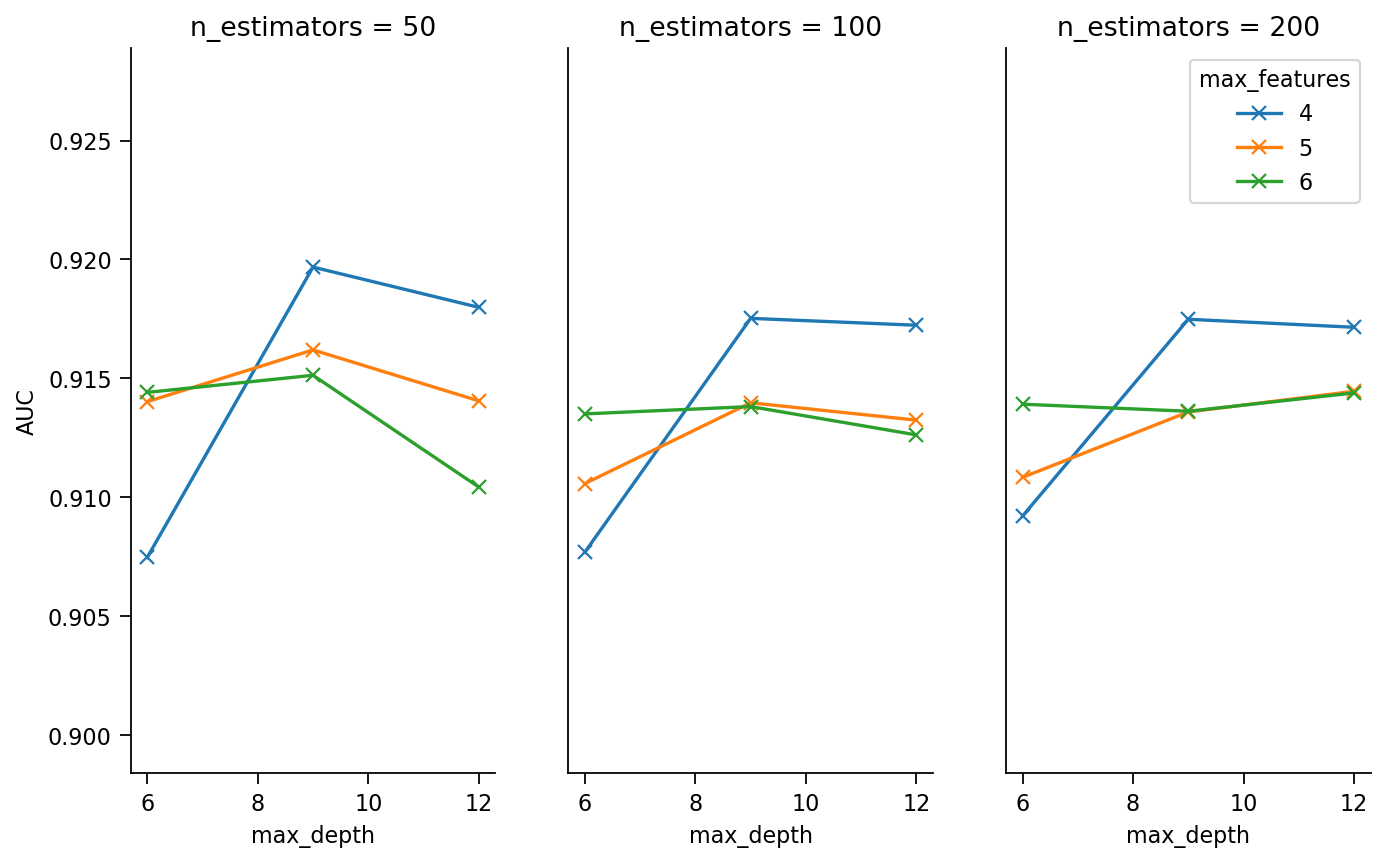

In [27]:
#-----------------------------------------------------------
#
# Visualise CV results
#
#-----------------------------------------------------------

rf_results = pd.DataFrame(grid_search_rf.cv_results_)

rf_plt_cols = ['param_random_forest__n_estimators',
               'param_random_forest__max_features',
               'param_random_forest__max_depth',
               'mean_test_score',
               'std_test_score']

rf_ = rf_results.loc[:, rf_plt_cols]
rf_ = rf_.rename(columns = {'param_random_forest__n_estimators':'n_estimators',
                      'param_random_forest__max_depth':'max_depth',
                      'param_random_forest__max_features':'max_features',
                      'mean_test_score' : 'AUC'})
        
train_plot(rf_, f_size = (10,6));

### Once again, it may be useful to rebuild features to examine attributes of the model

The features will be different, as we made different choices in our data processing steps in the pipeline. Most notably, we didnt allow polynomial features to be generated.

In [28]:
# can access parts of the CV pipeline object like so:
num_pipe_lr = grid_search_lr.best_estimator_.get_params()['union__num_pipeline']
cat_pipe_lr = grid_search_lr.best_estimator_.get_params()['union__cat_pipeline']

# names from numerical pipeline
names_1a = num_pipe_lr.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
names_2a = num_pipe_lr.get_params()['correlation'].get_feature_names(names_1a)
names_3a = num_pipe_lr.get_params()['poly_features'].get_feature_names(names_2a)

# names from categorical pipeline
names_1b = cat_pipe_lr.get_params()['manual_dropper'].get_feature_names(np.array(fac_col_names))
names_2b = cat_pipe_lr.get_params()['zero_var'].get_feature_names(np.array(names_1b))
names_3b = cat_pipe_lr.get_params()['correlation'].get_feature_names(np.array(names_2b))

# names following final correlation check
names_1c = np.array(names_3a + names_3b.tolist())
lr_feature_names = grid_search_lr.best_estimator_.get_params()['correlation'].get_feature_names(names_1c)

In [29]:
# rebuild features. Notice we selected polynomial terms
# can access parts of the pipeline like so
num_pipe_rf = grid_search_rf.best_estimator_.get_params()['union__num_pipeline']
cat_pipe_rf = grid_search_rf.best_estimator_.get_params()['union__cat_pipeline']

names_1a = num_pipe_rf.get_params()['zero_var'].get_feature_names(np.array(float_cols + int_cols))
names_2a = num_pipe_rf.get_params()['correlation'].get_feature_names(names_1a)
names_3a = num_pipe_rf.get_params()['poly_features'].get_feature_names(names_2a)

names_1b = cat_pipe_rf.get_params()['manual_dropper'].get_feature_names(np.array(fac_col_names))
names_2b = cat_pipe_rf.get_params()['zero_var'].get_feature_names(np.array(names_1b))
names_3b = cat_pipe_rf.get_params()['correlation'].get_feature_names(np.array(names_2b))

names_1c = np.array(names_3a + names_3b.tolist())
rf_feature_names = grid_search_rf.best_estimator_.get_params()['correlation'].get_feature_names(names_1c)

In [30]:
# Lets look at feature importance - relates to how many times the
# feature was chosen for a split in the tree

rf_model = grid_search_rf.best_estimator_.get_params()['random_forest']
rf_importance = rf_model.feature_importances_
sorted(list(zip( rf_importance, rf_feature_names )), key = lambda x: x[0], reverse=True)

[(0.2888154618490502, 'total_day_charge'),
 (0.1342172939359638, 'number_customer_service_calls'),
 (0.1079593276683282, 'international_plan_yes'),
 (0.10144963270771906, 'total_eve_charge'),
 (0.0772809598832494, 'total_intl_charge'),
 (0.06418315841134863, 'total_intl_calls'),
 (0.051622678297461595, 'total_night_charge'),
 (0.03897038207908449, 'voice_mail_plan_yes'),
 (0.036187368627636024, 'total_day_calls'),
 (0.03234287532112373, 'account_length'),
 (0.030268483426447612, 'total_night_calls'),
 (0.025337171775807157, 'total_eve_calls'),
 (0.004245539143079909, 'area_code_area_code_408'),
 (0.0036018317457514994, 'area_code_area_code_510'),
 (0.0035178351279487406, 'area_code_area_code_415')]

# Class imbalance

We saw there was class imbalace- it wasnt too severe (about 85% positive class), but we would be interested to see how sampling affects a model.

Up (or down) sampling is a common approach to address imbalance (Kuhn, Johnson: Applied Predictive Modelling)

This is an interesting problem- all of our pipeline considerations have been acting on __columns__, but now we need to operate on __rows__

We have implemented a factory which makes use of a mixin to alter the behaviour of Scikit Learn model classes. This mixin hijacks the fit method on the model, and performs up/down sampling on rows before the model is fit. We have to override the \_get_param_names class method in the BaseEstimator to allow us to pass keyword arguments into our generated class. __Be careful, we have reversed a design decision by doing this.__

We will demonstrate this by seeing if upsampling the minority class (customer did churn) can improve our model.


In [31]:
# have a look at the code to see how this is implemented!
from sampling import sample_clf_factory

In [32]:
LogisticRegressionWithSampling = sample_clf_factory(LogisticRegression)

lr_upsample_est = copy.deepcopy(prep_pipe)
lr_upsample_est.steps.append(('lr_upsample', LogisticRegressionWithSampling(random_state=1234, target_class=1)))

lr_us_param_grid = dict(
    union__num_pipeline__opt_scaler__scale=[True, False],
    union__num_pipeline__poly_features__degree=[1, 2],
    lr_upsample__penalty=['l1'],
    lr_upsample__C=[0.01, 0.1, 1.0],
    lr_upsample__sample_prop=[1.0, 1.05, 1.1, 1.15]
)

In [33]:
grid_search_lr_us = GridSearchCV(estimator=lr_upsample_est,
                              param_grid=lr_us_param_grid,
                              scoring='roc_auc',
                              n_jobs=3,
                              cv=5,
                              refit=True,
                              verbose=1)
grid_search_lr_us.fit(features_train, outcome_train);


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 144 tasks      | elapsed:   14.9s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:   33.5s finished


In [34]:
# GridSearchCV object has many useful attributes, for example:
#
print('Chosen params: {}\n\nTrain AUC score: {:0.3f}'.format(grid_search_lr_us.best_params_,
                                                        grid_search_lr_us.best_score_))

Chosen params: {'lr_upsample__C': 0.1, 'lr_upsample__penalty': 'l1', 'lr_upsample__sample_prop': 1.05, 'union__num_pipeline__opt_scaler__scale': True, 'union__num_pipeline__poly_features__degree': 2}

Train AUC score: 0.881


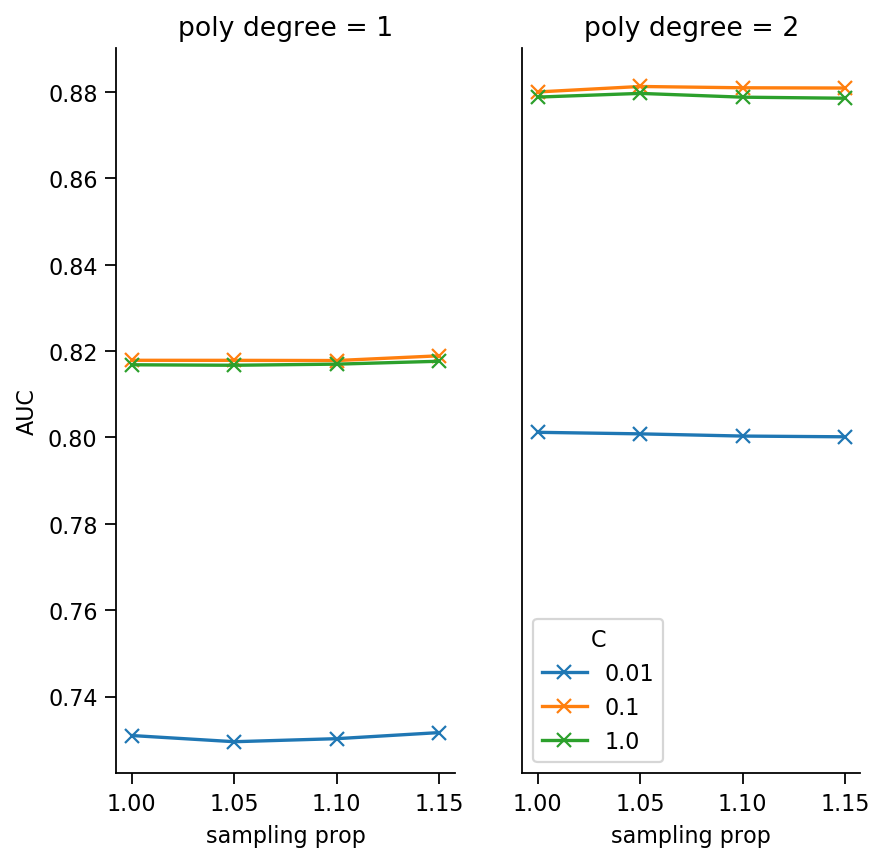

In [35]:
# plot for where poly degree = 2
lr_us_results = pd.DataFrame(grid_search_lr_us.cv_results_)
plt_cols = ['param_union__num_pipeline__poly_features__degree',
            'param_lr_upsample__C',
            'param_lr_upsample__sample_prop',
            'mean_test_score',
            'std_test_score']

lr_us_results_ = (
    lr_us_results.query('param_union__num_pipeline__opt_scaler__scale == True')
                 .loc[:, plt_cols]
                 .rename(columns = {'param_union__num_pipeline__poly_features__degree' : 'poly degree',
                                    'param_lr_upsample__C' : 'C',
                                    'param_lr_upsample__sample_prop' :'sampling prop',
                                    'mean_test_score' : 'AUC'
                                    })
)

train_plot(lr_us_results_)

### Was upsampling the minority class effective here?

We see a small (and mostly insignificant improvement here)

However, the purpose is to demonstrate _how_ you might implement such a solution to modify the behaviour of a sklearn estimator. This is useful to experiment with- in this case it may not imprvove the quality of the model, but in instances where a more severe class imbalance is present, it may be an essential technique.

# Model evaluation

Time for evaluation on the test set! The main purpose is to demonstrate that we can now feed the test data through the same pipeline using the predict() method. Remember, our pipeline object is wrapped up in a GridSearchCV object. This is really neat- it means we dont have to manually perform the same preprocessing steps on the test data set: the predict method will just apply the best model stored in the object.

We will look at a few perfomance metrics and graphics to interpret the final results as well.

In [36]:
# create the test features- use pandas to create 'dummies' for 
# categoricals
fac_dummies_test = pd.get_dummies(features_test.loc[:, fac_cols])
features_test = fac_dummies_test.merge(features_test.loc[:, int_cols + float_cols],
                    left_index = True, right_index = True)

# predictions: 'hard' (i.e. class, based on a 0.5 threshold)
# and probability, i.e. probability positive class
lr_predictions = grid_search_lr.predict(features_test)
lr_prob = grid_search_lr.predict_proba(features_test)[:, 1]

lr_us_predictions = grid_search_lr_us.predict(features_test)
lr_us_prob = grid_search_lr_us.predict_proba(features_test)[:, 1]

rf_predictions = grid_search_rf.predict(features_test)
rf_prob = grid_search_rf.predict_proba(features_test, )[:, 1]

We will consider the ROC curve initially, as we chose it as our metric for cross validation. I chose it as a 'safe' option: it is a useful metric as we get some degree of balance between sensitivity and specificity of the model. A 'perfect' model has an AUC of 1. 

We can plot the curves using the ROCPlot() class, and calculate the AUC with roc_auc_score():

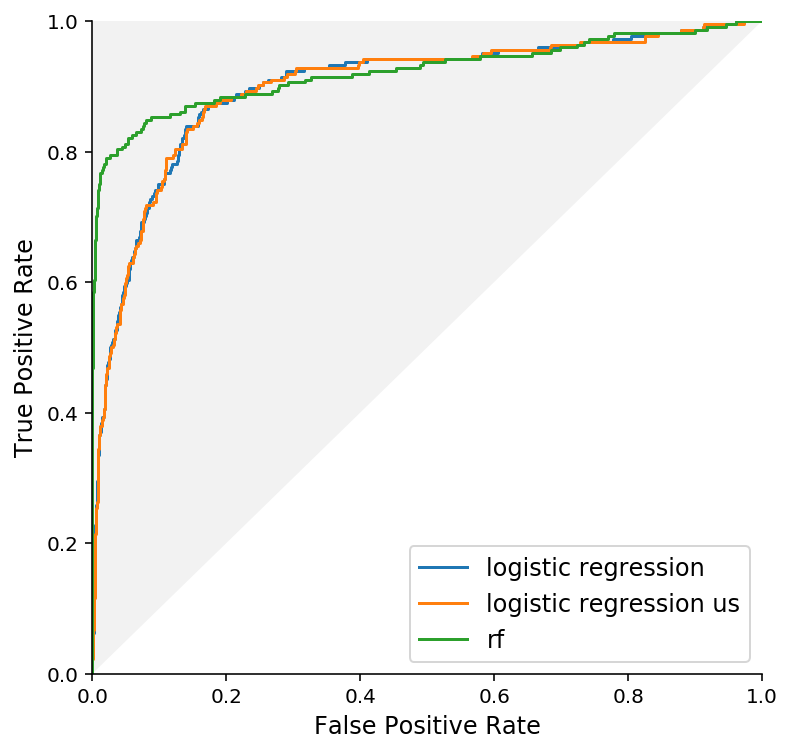

In [37]:
# intialise object
roc = ROCPlot(outcome_test.values) 
# add predictions from models
# roc.calc_roc(rf_prob, 'random forest')
roc.calc_roc(lr_prob, 'logistic regression')
roc.calc_roc(lr_us_prob, 'logistic regression us')
roc.calc_roc(rf_prob, 'rf')


# use buit in helper method for plotting
roc.plot(figsize = (6,6));

In [38]:
print('''
Logistic regression AUC: {:0.3f}
Logistic regression with upsample AUC: {:0.3f}
Random Forest AUC: {:0.3f}
'''.format(roc_auc_score(outcome_test,lr_prob),
           roc_auc_score(outcome_test, lr_us_prob),
           roc_auc_score(outcome_test, rf_prob))
     )


Logistic regression AUC: 0.901
Logistic regression with upsample AUC: 0.900
Random Forest AUC: 0.924



However, it is always useful to consider metrics that are applicable for the model use case. Presumably we would want to reach customers who are at risk of churn. Perhaps give them an offer (at our expense) to stop them churning.

Therefore, to maximise ROI for a campaign like this, we want to only send offers to customers who will truely churn: False positives would not have churned, and we may have sent them an offer for no reason.

A lift chart is a nice approach when considering how you might proactially use the model. We order the preddicted probabilities from highest to lowest, and we consider the percentage of positive events (churns) we find as a function of how many samples we test.

A business decision could be made to reach, say, 75% of customers who will churn. We can then read off our lift chart to see how much of the population we would have to contact to achieve this.

We see that using our logistic regression model, to catch 75% of churners, we have to test about 20% of our customer base. However, for the random forest model, we would only have to test about 10%, which could give us significant savings! We also see that we can get no false positives for up to about 70% of churning customers if we use the random forest model.

It is interesting to observe that to find more than 90% of customers, both models are as effective as one another (we would have to test about 35% of customers in both cases). This isnt unusual- some customers may churn in reality with behaviour that is typical of customers who do not churn. A better model, either using more features, more training data, or a different learning algorithm could be investigated to try and improve this.

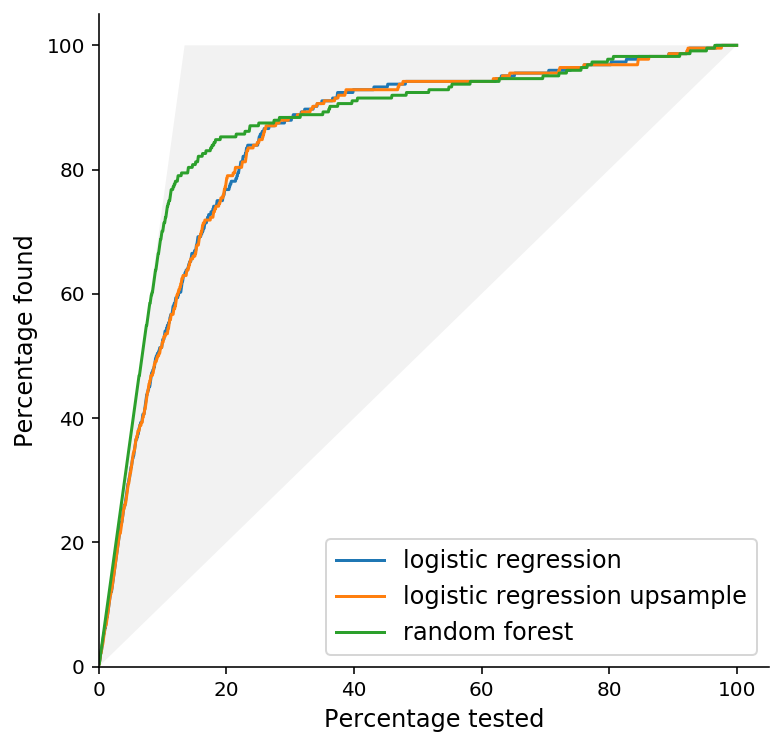

In [39]:
# initialise object
lift = LiftChart(outcome_test.values) 
# add the predictions
lift.calc_uplift(lr_prob, 'logistic regression')
lift.calc_uplift(lr_us_prob, 'logistic regression upsample')
lift.calc_uplift(rf_prob, 'random forest')


# built in helper method for plotting
lift.plot(thresh_pct=None, figsize = (6,6));

# Summary

Overall, we have demonstrated how to use sklearn pipelines to process data and fit learning algorithms, selecting the best combination of preprocessing and model parameters. We focussed on the Pipeline, FeatureUnion and GridSearchCV classes. We have also investigated some techniques for evaluating the results of our churn model.